In [22]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')


import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

import diffusion_dist as diff
import dataset as dataset
import model as model
import loss as loss
import train as train_mmd
import TI as ti
import benchmark as bmk
import scipy.sparse as sp

from umap import UMAP

import utils as utils

import post_align as palign
from scipy.sparse import load_npz
plt.rcParams["font.size"] = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simulated Cluster

In [ ]:
data_name = "2b3c_sigma0.1_b1_1"
counts_rna = pd.read_csv("../data/all_simulations/" + data_name + "/GxC1.txt", sep = "\t", header = None).values.T
counts_atac = pd.read_csv("../data/all_simulations/" + data_name + "/RxC2.txt", sep = "\t", header = None).values.T
label_rna = pd.read_csv("../data/all_simulations/" + data_name + "/cell_label1.txt", sep = "\t")["pop"].values.squeeze()
label_atac = pd.read_csv("../data/all_simulations/" + data_name + "/cell_label2.txt", sep = "\t")["pop"].values.squeeze()
libsize = 100
counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:, None] * libsize
counts_rna = np.log1p(counts_rna)
counts_atac = (counts_atac > 0).astype(np.float)


In [ ]:
seeds = [0]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 0.01
reg_mmd = 10
ts = [10]
use_potential = True
norm = "l1"

for seed in seeds:
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)


    # preprocessing
    libsize = 100

    rna_dataset = dataset.dataset(counts = counts_rna, anchor = None)
    atac_dataset = dataset.dataset(counts = counts_atac, anchor = None)
    coarse_reg = torch.FloatTensor(pd.read_csv("../data/all_simulations/" + data_name + "/region2gene.txt", sep = "\t", header = None).values).to(device)
    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        'learning_rate': learning_rate,
        'n_epochs': n_epochs + 1,
        'use_anchor': use_anchor,
        'reg_d': reg_d,
        'reg_g': reg_g,
        'reg_mmd': reg_mmd,
        'l_dist_type': 'kl',
        'device': device
    }

    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)

    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}

    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

    # training models
    losses = train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                    data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])

    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

    # np.save(file = "../test/results_snare/z_rna.npy", arr = z_rna.numpy())
    # np.save(file = "../test/results_snare/z_atac.npy", arr = z_atac.numpy())

    umap_op = UMAP(n_components = 2)
    z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna_pca = z[:z_rna.shape[0], :]
    z_atac_pca = z[z_rna.shape[0]:, :]

    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                        anno2 = label_atac, mode = "joint", save = "discrete_cluster.png", 
                        figsize = (10,7), axis_label = "PCA")
    
    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                        anno2 = label_atac, mode = "modality", save = "discrete_cluster_mod.png", 
                        figsize = (12,7), axis_label = "PCA")



# ASAP-PBMC

In [ ]:
dir = '../data/ASAP-PBMC/'

counts_rnas = []
counts_atacs = []
for batch in range(1,5):
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = (counts_atac > 0).astype(np.float)

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        libsize = 100
        counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:, None] * libsize
        counts_rna = np.log1p(counts_rna)
    
    except:
        counts_rna = None
    
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())

interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name


labels = []
for batch in range(0,4):
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())

In [ ]:
seeds = [0, 1, 2]
latent_dim = 8
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 10
reg_g = 1
reg_mmd = 1
ts = [5]
use_potential = True
norm = "l1"

for seed in seeds:
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)


    # preprocessing
    rna_dataset = dataset.dataset(counts = counts['rna'][0][::5,:], anchor = None)
    atac_dataset = dataset.dataset(counts = counts["atac"][3][::5,:], anchor = None)
    coarse_reg = torch.FloatTensor(A.T).to(device)

    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        'learning_rate': learning_rate,
        'n_epochs': n_epochs + 1,
        'use_anchor': use_anchor,
        'reg_d': reg_d,
        'reg_g': reg_g,
        'reg_mmd': reg_mmd,
        'l_dist_type': 'kl',
        'device': device
    }

    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)

    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}

    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

    # training models
    losses = train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                    data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])

    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

    # np.save(file = "../test/results_snare/z_rna.npy", arr = z_rna.numpy())
    # np.save(file = "../test/results_snare/z_atac.npy", arr = z_atac.numpy())

    # with torch.no_grad():
    #     z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    #     z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

    # post-maching
    pca_op = UMAP(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]

    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = labels[0][::5], 
                        anno2 = labels[3][::5], mode = "separate", save = None, 
                        figsize = (20,7), axis_label = "PCA")


# CellLineMixture

In [ ]:
counts_rna = pd.read_csv("../data/CellLineMixture/counts_rna.csv", sep = ",", index_col = 0).values
counts_atac = pd.read_csv("../data/CellLineMixture/counts_atac.csv", sep = ",", index_col = 0).values
labels_rna = pd.read_csv("../data/CellLineMixture/labels.csv", sep = ",", index_col = 0).values
labels_atac = pd.read_csv("../data/CellLineMixture/labels.csv", sep = ",", index_col = 0).values

In [ ]:
seeds = [0]
latent_dim = 8
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 100
reg_g = 0.000
reg_mmd = 1
ts = [5]
use_potential = True
norm = "l1"

seed = seeds[0]
print("Random seed: " + str(seed))
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


# preprocessing
libsize = 100

rna_dataset = dataset.dataset(counts = counts_rna, anchor = None)
atac_dataset = dataset.dataset(counts = counts_atac, anchor = None)
coarse_reg = torch.FloatTensor(pd.read_csv("../data/CellLineMixture/region2gene.csv", sep = ",", index_col = 0).values).to(device)

batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

EMBED_CONFIG = {
    'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
    'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
    'learning_rate': learning_rate,
    'n_epochs': n_epochs + 1,
    'use_anchor': use_anchor,
    'reg_d': reg_d,
    'reg_g': reg_g,
    'reg_mmd': reg_mmd,
    'l_dist_type': 'kl',
    'device': device
}

# calculate the diffusion distance
dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "pca", n_components = 30)

dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "lsi", n_components = 30)

dist_rna = dist_rna/np.linalg.norm(dist_rna)
dist_atac = dist_atac/np.linalg.norm(dist_atac)
dist_rna = torch.FloatTensor(dist_rna).to(device)
dist_atac = torch.FloatTensor(dist_atac).to(device)

# initialize the model
gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
model_dict = {"gene_act": gene_act, "encoder": encoder}

opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

# training models
losses = train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                mode = EMBED_CONFIG["l_dist_type"])

with torch.no_grad():
    z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
    z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

# np.save(file = "../test/results_snare/z_rna.npy", arr = z_rna.numpy())
# np.save(file = "../test/results_snare/z_atac.npy", arr = z_atac.numpy())

print(bmk.neigh_overlap(z_rna, z_atac, k = 50))


In [ ]:
from scipy.io import mmread
counts_atac_full = mmread("../data/CellLineMixture/counts_atac_full.mtx").todense().T
z = diff.lsi_ATAC(counts_atac_full, k = 30, use_first = False)
umap_op = UMAP(n_components = 2, min_dist = 0.1)
z = umap_op.fit_transform(z)

utils.plot_latent(z1 = z, z2 = z, anno1 = labels_rna, 
                    anno2 = labels_atac, mode = "separate", save = None, 
                    figsize = (20,7), axis_label = "PCA")

In [ ]:
# with torch.no_grad():
#     z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
#     z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

# post-maching
pca_op = UMAP(n_components = 2)
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna_pca = z[:z_rna.shape[0],:]
z_atac_pca = z[z_rna.shape[0]:,:]

utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = labels_rna, 
                    anno2 = labels_atac, mode = "separate", save = None, 
                    figsize = (20,7), axis_label = "PCA")

# Paired dataset

In [ ]:
import importlib 
importlib.reload(train_mmd)

In [ ]:
seeds = [0]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 1
reg_mmd = 10
ts = [30, 50, 70]
use_potential = True
norm = "l1"

seed = seeds[0]
print("Random seed: " + str(seed))
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

rna_dataset = dataset.hema_rna(counts_dir = "../data/snare-seq-1000/counts_rna.csv", 
                                      anno_dir = "../data/snare-seq-1000/anno.txt",anchor = None)
atac_dataset = dataset.hema_atac(counts_dir = "../data/snare-seq-1000/counts_atac.csv", 
                                        anno_dir = "../data/snare-seq-1000/anno.txt",anchor = None)
coarse_reg = torch.FloatTensor(pd.read_csv("../data/snare-seq-1000/region2gene.csv", sep = ",", index_col = 0).values).to(device)

batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
libsize = rna_dataset.get_libsize()

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

EMBED_CONFIG = {
    'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
    'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
    'learning_rate': learning_rate,
    'n_epochs': n_epochs + 1,
    'use_anchor': use_anchor,
    'reg_d': reg_d,
    'reg_g': reg_g,
    'reg_mmd': reg_mmd,
    'l_dist_type': 'kl',
    'device': device
}

# calculate the diffusion distance
dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "pca", n_components = 30)

dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "lsi", n_components = 30)

dist_rna = dist_rna/np.linalg.norm(dist_rna)
dist_atac = dist_atac/np.linalg.norm(dist_atac)
dist_rna = torch.FloatTensor(dist_rna).to(device)
dist_atac = torch.FloatTensor(dist_atac).to(device)

# initialize the model
gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
model_dict = {"gene_act": gene_act, "encoder": encoder}

opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

# training models
losses = train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                mode = EMBED_CONFIG["l_dist_type"])

with torch.no_grad():
    z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
    z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

# torch.save(model_dict, "../test/results_snare/models_1000/model_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".pth")
# np.save(file = "../test/results_snare/models_1000/z_rna_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".npy", arr = z_rna.numpy())
# np.save(file = "../test/results_snare/models_1000/z_atac_" + str(latent_dim) + "_" + str(reg_d) + "_" + str(reg_g) + "_" + str(reg_mmd) + "_" + str(seed) + "_" + norm + ".npy", arr = z_atac.numpy())

print(bmk.neigh_overlap(z_rna, z_atac, k = 50))


In [ ]:
# with torch.no_grad():
#     z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
#     z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

# post-maching
pca_op = PCA(n_components = 2)
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna_pca = z[:z_rna.shape[0],:]
z_atac_pca = z[z_rna.shape[0]:,:]

utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, 
                    anno2 = atac_dataset.cell_labels, mode = "separate", save = None, 
                    figsize = (20,7), axis_label = "PCA")

In [ ]:
from scipy.stats import pearsonr, spearmanr
# root, manually found
root_cell = 450
# scdart
dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
pt_infer_scdart = dpt_mtx[root_cell, :]
pt_infer_scdart[pt_infer_scdart.argsort()] = np.arange(len(pt_infer_scdart))
pt_infer_scdart = pt_infer_scdart/np.max(pt_infer_scdart)
spearman_scdart, _ = spearmanr(pt_infer_scdart[:z_rna.shape[0]], pt_infer_scdart[z_rna.shape[0]:])
pearson_scdart, _ = pearsonr(pt_infer_scdart[:z_rna.shape[0]], pt_infer_scdart[z_rna.shape[0]:])
print("scDART: spearman: {:.4f}, pearson: {:.4f}".format(spearman_scdart, pearson_scdart))

In [ ]:
# prediction accuracy
pseudo_rna = model_dict["gene_act"](atac_dataset.counts.to(device)).detach().cpu().numpy()
mse = np.sum((pseudo_rna - real_rna) ** 2)/pseudo_rna.shape[0]
mse_norm = np.sum((pseudo_rna/np.sum(pseudo_rna, axis = 1, keepdims = True) - real_rna/np.sum(real_rna, axis = 1, keepdims = True)) ** 2)/pseudo_rna.shape[0]
pearson = sum([pearsonr(pseudo_rna[i,:], real_rna[i,:])[0] for i in range(pseudo_rna.shape[0])])/pseudo_rna.shape[0]
spearman = sum([spearmanr(pseudo_rna[i,:], real_rna[i,:])[0] for i in range(pseudo_rna.shape[0])])/pseudo_rna.shape[0]
print(mse)
print(mse_norm)
print(pearson)
print(spearman)

In [ ]:
seeds = [0]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 0
reg_mmd = 20
ts = [30, 50, 70]
use_potential = True
norm = "l1"

seed = seeds[0]
print("Random seed: " + str(seed))
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

rna_dataset = dataset.hema_rna(counts_dir = "../data/snare-seq-1000/counts_rna.csv", 
                                      anno_dir = "../data/snare-seq-1000/anno.txt",anchor = None)
atac_dataset = dataset.hema_atac(counts_dir = "../data/snare-seq-1000/counts_atac.csv", 
                                        anno_dir = "../data/snare-seq-1000/anno.txt",anchor = None)
coarse_reg = torch.FloatTensor(pd.read_csv("../data/snare-seq-1000/region2gene.csv", sep = ",", index_col = 0).values).to(device)

batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
libsize = rna_dataset.get_libsize()

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

EMBED_CONFIG = {
    'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
    'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
    'learning_rate': learning_rate,
    'n_epochs': n_epochs + 1,
    'use_anchor': use_anchor,
    'reg_d': reg_d,
    'reg_g': reg_g,
    'reg_mmd': reg_mmd,
    'l_dist_type': 'kl',
    'device': device
}

# calculate the diffusion distance
dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "pca", n_components = 30)

dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "lsi", n_components = 30)

dist_rna = dist_rna/np.linalg.norm(dist_rna)
dist_atac = dist_atac/np.linalg.norm(dist_atac)
dist_rna = torch.FloatTensor(dist_rna).to(device)
dist_atac = torch.FloatTensor(dist_atac).to(device)

# initialize the model
gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
model_dict = {"gene_act": gene_act, "encoder": encoder}

opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

# training models
losses_null = train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                mode = EMBED_CONFIG["l_dist_type"])

with torch.no_grad():
    z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
    z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

# np.save(file = "../test/results_snare/z_rna.npy", arr = z_rna.numpy())
# np.save(file = "../test/results_snare/z_atac.npy", arr = z_atac.numpy())

print(bmk.neigh_overlap(z_rna, z_atac, k = 50))


# simulated dataset

In [ ]:
def plot_backbone(z1, z2, T, mean_cluster, groups, anno, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.4,
        "markerscale": 6,
        "fontsize": 20
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)

    if mode == "joint":
        ax = fig.add_subplot()
        cluster_types = np.sort(np.unique(groups))
        cmap = plt.cm.get_cmap("tab20", len(np.unique(anno)))
        if (z1 is not None) and (z2 is not None):
            z = np.concatenate((z1, z2), axis = 0)
        elif z1 is not None:
            z = z1
        else:
            z = z2

        for i, cat in enumerate(np.sort(np.unique(anno))):
            idx = np.where(anno == cat)[0]
            ax.scatter(z[idx,0], z[idx,1], color = cmap(i), cmap = 'tab20', label = cat, alpha = _kwargs["alpha"], s = _kwargs["s"])
    
    elif mode == "modality":
        colormap = plt.cm.get_cmap("tab10")
        ax = fig.add_subplot()
        ax.scatter(z1[:,0], z1[:,1], color = colormap(1), label = "scRNA-Seq", s = _kwargs["s"], alpha = _kwargs["alpha"])
        ax.scatter(z2[:,0], z2[:,1], color = colormap(2), label = "scATAC-Seq", s = _kwargs["s"], alpha = _kwargs["alpha"])
        ax.legend(loc='upper left', frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1), markerscale = _kwargs["markerscale"])
        
        ax.tick_params(axis = "both", which = "major", labelsize = 15)

        ax.set_xlabel(axis_label + " 1", fontsize = 19)
        ax.set_ylabel(axis_label + " 2", fontsize = 19)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  

    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            if T[i,j] != 0:
                ax.plot([mean_cluster[i, 0], mean_cluster[j, 0]], [mean_cluster[i, 1], mean_cluster[j, 1]], 'r-')

    ax.scatter(mean_cluster[:,0], mean_cluster[:,1], color = "red", s = 30)

    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False, markerscale = _kwargs["markerscale"])

    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)

def calc_score(z, pt, cell_labels, plot = None):
    # calculate the diffusion pseudotime
    dpt_mtx = ti.dpt(z, n_neigh = 10)
    pt_infer = dpt_mtx[np.argmin(pt), :]
    pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
    pt_infer = pt_infer/np.max(pt_infer)

    pt_true = pt
    pt_true[pt_true.argsort()] = np.arange(len(pt_true))
    pt_true = pt_true/np.max(pt_true)
        
    groups, mean_cluster, conn = ti.backbone_inf(z, resolution = 0.5)
    mean_cluster = np.array(mean_cluster)
    root = groups[np.argmin(pt_infer)]
    G = nx.from_numpy_matrix(conn)
    T = nx.dfs_tree(G, source = root)
    
    # find trajectory backbone
    branching_nodes = [x for x,d in T.out_degree() if (d >= 2)]
    paths = [nx.shortest_path(G, source = root, target = x) for x,d in T.out_degree() if (d == 0)]
    branches = []
    for path in paths:
        last_idx = 0
        for idx, node in enumerate(path):
            if node in branching_nodes:
                if len(path[last_idx:idx]) > 0:
                    branches.append(path[last_idx:idx])
                    last_idx = idx
        if len(path[last_idx:]) > 0:
            branches.append(path[last_idx:])         
    branches = sorted(list(set(map(tuple,branches))))

    # find cells for all branches
    cell_labels_predict = np.zeros(groups.shape)
    for idx, branch in enumerate(branches):
        for x in branch:
            cell_labels_predict[groups == x] = idx
            
    F1 = bmk.F1_branches(branches = cell_labels, branches_gt = cell_labels_predict)
    kt = bmk.kendalltau(pt_infer, pt_true)
    if plot is not None:
        plot_backbone(z, None, groups = groups, anno = cell_labels, 
                  T = conn, mean_cluster = mean_cluster, mode = "joint", figsize=(10,7), 
                  save = plot, axis_label = "LSI")
    return F1, kt

In [ ]:
seeds = [0]
latent_dims = [4, 8, 32]
reg_ds = [1, 10]
reg_gs = [0.01, 1, 10]
reg_mmds = [1, 10, 20, 30]

latent_dim = latent_dims[1]
reg_d = reg_ds[0]
reg_g = reg_gs[1]
# harder to merge, need to make mmd loss larger
reg_mmd = reg_mmds[0]

learning_rate = 3e-4
n_epochs = 500
use_anchor = True
ts = [30, 50, 70]
use_potential = True
norm = "l1"

for seed in seeds:
    start_time = time.time()
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

#     rna_dataset = symsim2_rna(counts_dir = "../data/all_simulations/trifur_new2/GxC1.txt", 
#                               anno_dir = "../data/all_simulations/trifur_new2/cell_label1.txt", 
#                               pt = "../data/all_simulations/trifur_new2/pseudotime1.txt",
#                               anchor = "4_1", libsize = 100)
#     atac_dataset = symsim2_atac(counts_dir = "../data/all_simulations/trifur_new2/RxC2.txt", 
#                                 anno_dir = "../data/all_simulations/trifur_new2/cell_label2.txt", 
#                                 pt = "../data/all_simulations/trifur_new2/pseudotime2.txt",
#                                 anchor = "4_1")
#     coarse_reg = torch.FloatTensor(pd.read_csv("../data/all_simulations/trifur_new2/region2gene.txt", sep = "\t", header = None).values).to(device)
    data_name = "trifur2"
    counts_rna = pd.read_csv("../data/simulated/" + data_name + "/GxC1.txt", sep = "\t", header = None).values.T
    counts_atac = pd.read_csv("../data/simulated/" + data_name + "/RxC2.txt", sep = "\t", header = None).values.T
    label_rna = pd.read_csv("../data/simulated/" + data_name + "/cell_label1.txt", sep = "\t")["pop"].values.squeeze()
    label_atac = pd.read_csv("../data/simulated/" + data_name + "/cell_label2.txt", sep = "\t")["pop"].values.squeeze()
    pt_rna = pd.read_csv("../data/simulated/" + data_name + "/pseudotime1.txt", header = None).values.squeeze()
    pt_atac = pd.read_csv("../data/simulated/" + data_name + "/pseudotime2.txt", header = None).values.squeeze()
        
    # preprocessing
    libsize = 100
    counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:, None] * libsize
    counts_rna = np.log1p(counts_rna)

    rna_dataset = dataset.dataset(counts = counts_rna, anchor = None)
    atac_dataset = dataset.dataset(counts = counts_atac, anchor = None)
    coarse_reg = torch.FloatTensor(pd.read_csv("../data/simulated/" + data_name + "/region2gene.txt", sep = "\t", header = None).values).to(device)


    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        "gact_layers": [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        "proj_layers": [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        "learning_rate": learning_rate,
        "n_epochs": n_epochs + 1,
        "use_anchor": use_anchor,
        "reg_d": reg_d,
        "reg_g": reg_g,
        "reg_mmd": reg_mmd,
        "l_dist_type": "kl",
        "device": device
    }

    start_time = time.time()
    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    # quantile normalization
    # dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)

    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}

    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

    # training models
    train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                    data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])
    
    print("calculation time {:.2f}".format(time.time() - start_time))
    
    # Plot results
    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()
    
    
    # Plot predict scRNA-Seq and real scRNA-Seq data
    pseudo_rna = model_dict["gene_act"](atac_dataset.counts.to(device)).detach().cpu().numpy()
    real_rna = rna_dataset.counts.detach().cpu().numpy()

    umap_op = UMAP(n_components = 2)
    z = umap_op.fit_transform(np.concatenate((real_rna, pseudo_rna), axis = 0))
    z_rna_pca = z[:real_rna.shape[0], :]
    z_atac_pca = z[real_rna.shape[0]:, :]

    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                        anno2 = label_atac, mode = "separate", save = None, 
                        figsize = (20,7), axis_label = "PCA")

    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]
    
    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                      anno2 = label_atac, mode = "separate", save = "../test/results_acc/trifur2.png", 
                      figsize = (30,10), axis_label = "PCA")
    # post-maching
    z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]

    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                      anno2 = label_atac, mode = "separate", save = "../test/results_acc/trifur2_post.png", 
                      figsize = (30,10), axis_label = "PCA")
    
    # calculate the diffusion distance
    root_cell = np.argmin(pt_rna)
    dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
    pt_infer = dpt_mtx[root_cell, :]
    pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
    pt_infer = pt_infer/np.max(pt_infer)

    pt_true = np.concatenate((pt_rna, pt_atac))
    pt_true[pt_true.argsort()] = np.arange(len(pt_true))
    pt_true = pt_true/np.max(pt_true)

    pt_rna = dpt_mtx[np.argmin(pt_rna), :z_rna.shape[0]]
    pt_atac = dpt_mtx[np.argmin(pt_rna), z_rna.shape[0]:]
    
    # backbone
    z = np.concatenate((z_rna, z_atac), axis = 0)
    cell_labels = np.concatenate((label_rna, label_atac), axis = 0).squeeze()
    
    # infer backbone with leiden clustering
    groups, mean_cluster, T = ti.backbone_inf(z, resolution = 0.05)
    groups_rna = groups[:counts_rna.shape[0]]
    groups_atac = groups[counts_rna.shape[0]:]
    root_clust = groups[root_cell]

    # infer all trajectories
    G = nx.from_numpy_matrix(T, create_using=nx.DiGraph)
    G = nx.dfs_tree(G, source = root_clust)
    paths = []
    for node in G:
        if G.out_degree(node)==0: #it's a leaf
            paths.append(nx.shortest_path(G, root_clust, node))

    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]    
    mean_cluster = pca_op.transform(np.array(mean_cluster))
    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = cell_labels, 
                  T = T, mean_cluster = mean_cluster, mode = "joint", figsize=(10,7), 
                  save = "../test/results_acc/trifur2_backbone.png", axis_label = "PCA")
    
    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = np.array(["scRNA-Seq"] * z_rna_pca.shape[0] + ["scATAC-Seq"] * z_atac_pca.shape[0]), 
                  T = T, mean_cluster = mean_cluster, mode = "modality", figsize=(10,7), 
                  save = "../test/results_acc/trifur2_backbone_modality.png", axis_label = "PCA")

In [ ]:
seeds = [0]
latent_dims = [4, 8, 32]
reg_ds = [1, 10]
reg_gs = [0.01, 1, 10]
reg_mmds = [1, 10, 20, 30]

latent_dim = latent_dims[1]
reg_d = reg_ds[1]
reg_g = reg_gs[1]
# harder to merge, need to make mmd loss larger
reg_mmd = reg_mmds[1]

learning_rate = 3e-4
n_epochs = 500
use_anchor = True
ts = [30, 50, 70]
use_potential = True
norm = "l1"

for seed in seeds:
    start_time = time.time()
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    data_name = "trifur2"
    counts_rna = pd.read_csv("../data/simulated/" + data_name + "/GxC1.txt", sep = "\t", header = None).values.T
    counts_atac = pd.read_csv("../data/simulated/" + data_name + "/RxC2.txt", sep = "\t", header = None).values.T
    label_rna = pd.read_csv("../data/simulated/" + data_name + "/cell_label1.txt", sep = "\t")["pop"].values.squeeze()
    label_atac = pd.read_csv("../data/simulated/" + data_name + "/cell_label2.txt", sep = "\t")["pop"].values.squeeze()
    # ground truth labels
    pt_rna = pd.read_csv("../data/simulated/" + data_name + "/pseudotime1.txt", header = None).values.squeeze()
    pt_atac = pd.read_csv("../data/simulated/" + data_name + "/pseudotime2.txt", header = None).values.squeeze()
    
    # remove part of the branch, leave only 100
    
#     remove_cells = np.where(label_rna == "4_1")[0]
#     remove_cells = np.concatenate((remove_cells[:29], remove_cells[50:79], remove_cells[100:129], 
#                                    remove_cells[150:179], remove_cells[200:229], remove_cells[250:279],
#                                    remove_cells[300:329], remove_cells[350:379], remove_cells[400:429],
#                                    remove_cells[450:479], remove_cells[500:529], remove_cells[550:579])) 
#     remove_cells = np.where(label_rna == "4_1")[0][::2]
#     indices = np.array([True] * label_rna.shape[0])
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_2")[0][::2]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_3")[0][::2]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_1")[0][::3]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_2")[0][::3]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_3")[0][::3]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_1")[0][::5]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_2")[0][::5]
#     indices[remove_cells] = False
#     remove_cells = np.where(label_rna == "4_3")[0][::5]
#     indices[remove_cells] = False

#     remove_cells = np.where(label_rna == "4_1")[0]
#     print(remove_cells.shape)
#     indices = np.array([True] * label_rna.shape[0])
#     remove_cells = np.random.choice(remove_cells, 600, replace = False)
#     indices[remove_cells] = False

    
    # preprocessing
    libsize = 100
    counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:, None] * libsize
    counts_rna = np.log1p(counts_rna)

    label_rna_new = np.where(label_rna == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0]) + " cells)", label_rna)
    label_rna_new = np.where(label_rna == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0]) + " cells)", label_rna_new)
    label_rna_new = np.where(label_rna == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0]) + " cells)", label_rna_new)
    label_atac_new = np.where(label_atac == "4_1", "4_1 (" + str(np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_atac)
    label_atac_new = np.where(label_atac == "4_2", "4_2 (" + str(np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_atac_new)
    label_atac_new = np.where(label_atac == "4_3", "4_3 (" + str(np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_atac_new)
    
    # calculate TI accuracy (pseudotime inferred separately)
    pca_op = PCA(n_components = 5)
    z_rna = pca_op.fit_transform(counts_rna)
    z_atac = pca_op.fit_transform(counts_atac)
    z_atac = diff.lsi_ATAC(X = counts_atac, k = 5)
    F1_rna, kt_rna = calc_score(z_rna, pt_rna, label_rna_new, plot = "ori_backbone_rna.png")
    F1_atac, kt_atac = calc_score(z_atac, pt_atac, label_atac_new, plot = "ori_backbone_atac.png")
    print("Accuracy (RNA), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_rna, kt_rna))
    print("Accuracy (ATAC), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_atac, kt_atac))    
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format((F1_rna + F1_atac)/2, (kt_rna + kt_atac)/2))

    
    # subsample
    indices = np.array([True] * label_rna.shape[0])
    remove_cells = np.random.choice(np.where(label_rna == "4_3")[0], 400, replace = False)
    indices[remove_cells] = False
    counts_rna = counts_rna[indices, :]
    label_rna = label_rna[indices]
    pt_rna = pt_rna[indices]
    
    indices = np.array([True] * label_atac.shape[0])
    remove_cells = np.random.choice(np.where(label_atac == "4_3")[0], 400, replace = False)
    indices[remove_cells] = False
    counts_atac = counts_atac[indices, :]
    label_atac = label_atac[indices]
    pt_atac = pt_atac[indices]

    print("remaining cells...")
    print("4_1, RNA", end = ", ")
    print(np.where(label_rna == "4_1")[0].shape[0])
    print("4_1, ATAC", end = ", ")
    print(np.where(label_atac == "4_1")[0].shape[0])
    print("4_2, RNA", end = ", ")
    print(np.where(label_rna == "4_2")[0].shape[0])
    print("4_2, ATAC", end = ", ")
    print(np.where(label_atac == "4_2")[0].shape[0])
    print("4_3, RNA", end = ", ")
    print(np.where(label_rna == "4_3")[0].shape[0])
    print("4_3, ATAC", end = ", ")
    print(np.where(label_atac == "4_3")[0].shape[0])
#     label_rna = np.where(label_rna == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0]) + " cells)", label_rna)
#     label_rna = np.where(label_rna == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0]) + " cells)", label_rna)
#     label_rna = np.where(label_rna == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0]) + " cells)", label_rna)
#     label_atac = np.where(label_atac == "4_1", "4_1 (" + str(np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_atac)
#     label_atac = np.where(label_atac == "4_2", "4_2 (" + str(np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_atac)
#     label_atac = np.where(label_atac == "4_3", "4_3 (" + str(np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_atac)
    label_rna_new = np.where(label_rna == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0] + np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_rna)
    label_rna_new = np.where(label_rna == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0] + np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_rna_new)
    label_rna_new = np.where(label_rna == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0] + np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_rna_new)
    label_atac_new = np.where(label_atac == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0] + np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_atac)
    label_atac_new = np.where(label_atac == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0] + np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_atac_new)
    label_atac_new = np.where(label_atac == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0] + np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_atac_new)
    
    
    pt = np.concatenate((pt_rna, pt_atac), axis = 0)
    label = np.concatenate((label_rna, label_atac), axis = 0)   
    
    # calculate TI accuracy (pseudotime inferred separately)
    pca_op = PCA(n_components = 5)
    z_rna = pca_op.fit_transform(counts_rna)
    z_atac = pca_op.fit_transform(counts_atac)
    z_atac = diff.lsi_ATAC(X = counts_atac, k = 6)
    F1_rna, kt_rna = calc_score(z_rna, pt_rna, label_rna_new, plot = "subsample_backbone_rna.png")
    F1_atac, kt_atac = calc_score(z_atac, pt_atac, label_atac_new, plot = "subsample_backbone_atac.png")
    print("Accuracy (RNA), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_rna, kt_rna))
    print("Accuracy (ATAC), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_atac, kt_atac))    
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format((F1_rna + F1_atac)/2, (kt_rna + kt_atac)/2))
#     # plot RNA
#     utils.plot_latent(z1 = z_rna, z2 = z_rna, anno1 = label_rna, 
#                   anno2 = label_rna, mode = "separate", save = None, 
#                   figsize = (30,10), axis_label = "PCA")
#     # plot ATAC
#     utils.plot_latent(z1 = z_atac, z2 = z_atac, anno1 = label_atac, 
#                   anno2 = label_atac, mode = "separate", save = None, 
#                   figsize = (30,10), axis_label = "PCA")
    
    rna_dataset = dataset.dataset(counts = counts_rna, anchor = None)
    atac_dataset = dataset.dataset(counts = counts_atac, anchor = None)
    coarse_reg = torch.FloatTensor(pd.read_csv("../data/simulated/" + data_name + "/region2gene.txt", sep = "\t", header = None).values).to(device)
    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        "gact_layers": [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        "proj_layers": [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        "learning_rate": learning_rate,
        "n_epochs": n_epochs + 1,
        "use_anchor": use_anchor,
        "reg_d": reg_d,
        "reg_g": reg_g,
        "reg_mmd": reg_mmd,
        "l_dist_type": "kl",
        "device": device
    }

    start_time = time.time()
    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                   use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    # quantile normalization
    # dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)
    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}
    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}
    # training models
    train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                    data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])
        
    # Plot results
    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]
#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
#                       anno2 = label_atac, mode = "separate", save = None, 
#                       figsize = (30,10), axis_label = "PCA")
    # post-maching
    z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

    # calculate accuracy
    F1, kt = calc_score(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0), pt, label)
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1, kt))
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]

#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
#                       anno2 = label_atac, mode = "separate", save = None, 
#                       figsize = (30,10), axis_label = "PCA")
    
    # calculate the diffusion distance
    root_cell = np.argmin(pt_rna)
    dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
    pt_infer = dpt_mtx[root_cell, :]
    pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
    pt_infer = pt_infer/np.max(pt_infer)

    pt_true = np.concatenate((pt_rna, pt_atac))
    pt_true[pt_true.argsort()] = np.arange(len(pt_true))
    pt_true = pt_true/np.max(pt_true)

    pt_rna = dpt_mtx[np.argmin(pt_rna), :z_rna.shape[0]]
    pt_atac = dpt_mtx[np.argmin(pt_rna), z_rna.shape[0]:]
    
    # backbone
    z = np.concatenate((z_rna, z_atac), axis = 0)
    cell_labels = np.concatenate((label_rna, label_atac), axis = 0).squeeze()
    
    # infer backbone with leiden clustering
    groups, mean_cluster, T = ti.backbone_inf(z, resolution = 0.05)
    groups_rna = groups[:counts_rna.shape[0]]
    groups_atac = groups[counts_rna.shape[0]:]
    root_clust = groups[root_cell]

    # infer all trajectories
    G = nx.from_numpy_matrix(T, create_using=nx.DiGraph)
    G = nx.dfs_tree(G, source = root_clust)
    paths = []
    for node in G:
        if G.out_degree(node)==0: #it's a leaf
            paths.append(nx.shortest_path(G, root_clust, node))

    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]    
    mean_cluster = pca_op.transform(np.array(mean_cluster))
    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = np.concatenate((label_rna_new, label_atac_new), axis = 0).squeeze(), 
                  T = T, mean_cluster = mean_cluster, mode = "joint", figsize=(10,7), 
                  save = "backbone.png", axis_label = "PCA")
    
    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = np.array(["scRNA-Seq"] * z_rna_pca.shape[0] + ["scATAC-Seq"] * z_atac_pca.shape[0]), 
                  T = T, mean_cluster = mean_cluster, mode = "modality", figsize=(10,7), 
                  save = "backbone_mod.png", axis_label = "PCA")
    

In [27]:
import importlib 
importlib.reload(train_mmd)

<module 'train' from '/localscratch/ziqi/scDART_proj/scDART_test/Example/../src/train.py'>

Random seed: 0
running Leiden clustering
finished
ori_backbone_rna.png
running Leiden clustering
finished
ori_backbone_atac.png
Accuracy (RNA), F1 score: 0.74, Kendall-tau score: 0.63
Accuracy (ATAC), F1 score: 0.60, Kendall-tau score: 0.54
Accuracy, F1 score: 0.67, Kendall-tau score: 0.59
remaining cells...
4_1, RNA, 344
4_1, ATAC, 647
4_2, RNA, 166
4_2, ATAC, 337
4_3, RNA, 247
4_3, ATAC, 502
running Leiden clustering
finished
subsample2_backbone_rna.png
running Leiden clustering
finished
subsample2_backbone_atac.png
Accuracy (RNA), F1 score: 0.69, Kendall-tau score: 0.57
Accuracy (ATAC), F1 score: 0.73, Kendall-tau score: 0.60
Accuracy, F1 score: 0.71, Kendall-tau score: 0.59
running time(sec): 0.3022763729095459
running time(sec): 0.28116917610168457
running time(sec): 0.2911851406097412
running time(sec): 0.9532160758972168
running time(sec): 0.9211902618408203
running time(sec): 0.9329760074615479
epoch:  0
	 mmd loss: 0.057
	 ATAC dist loss: 0.630
	 RNA dist loss: 0.227
	 gene ac

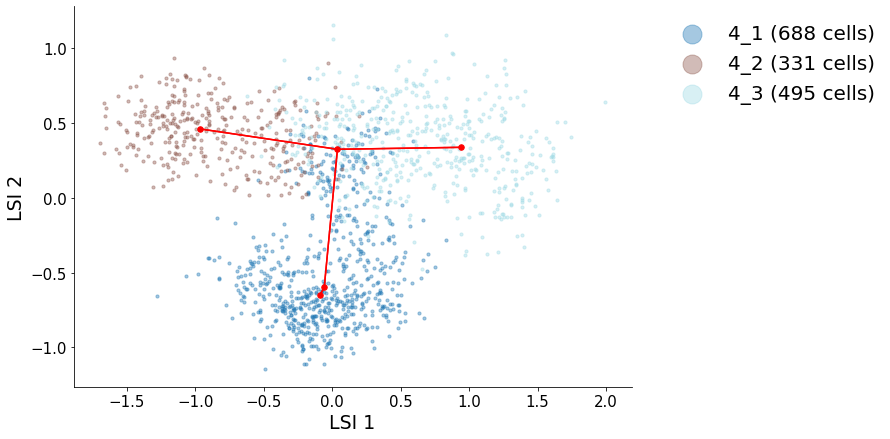

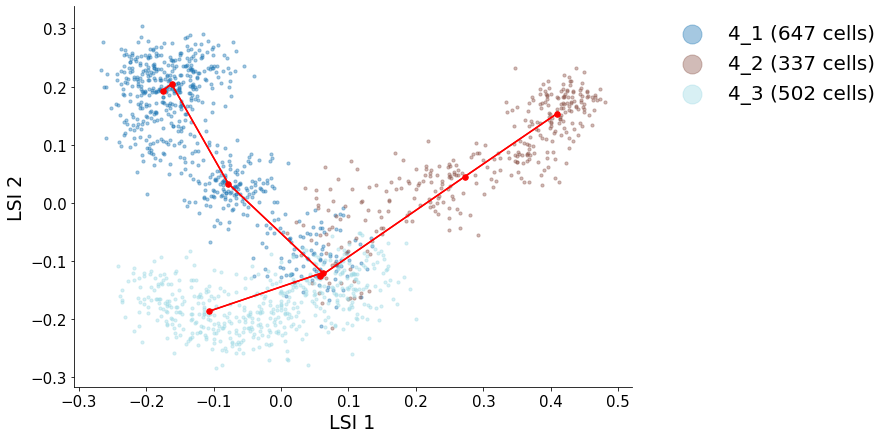

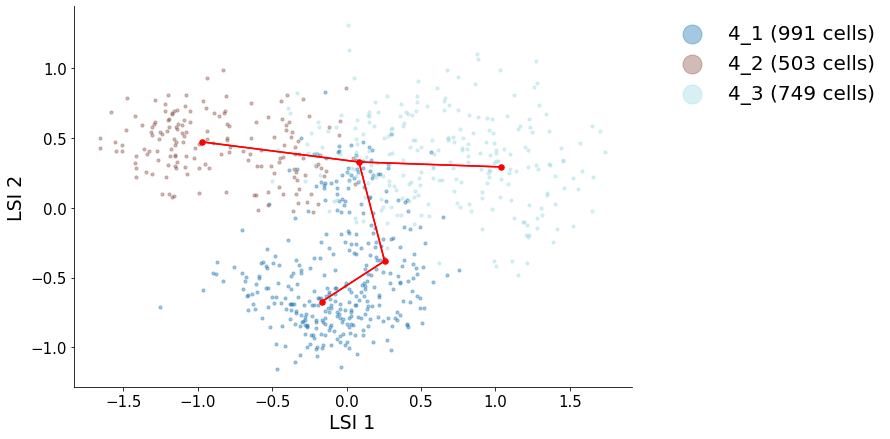

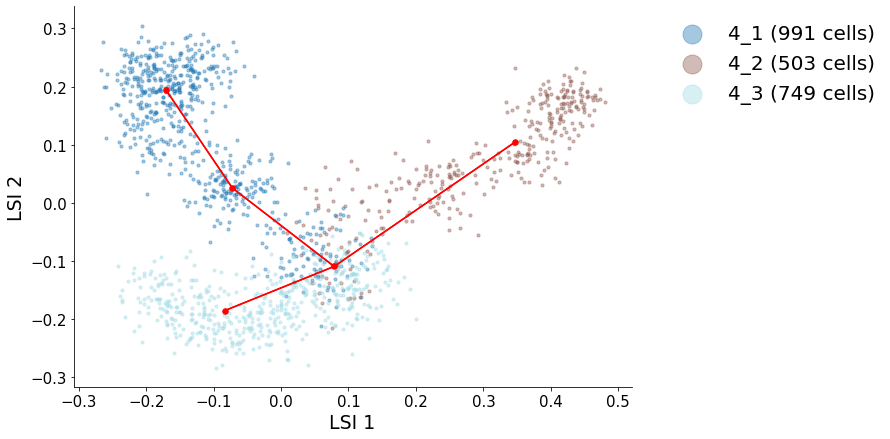

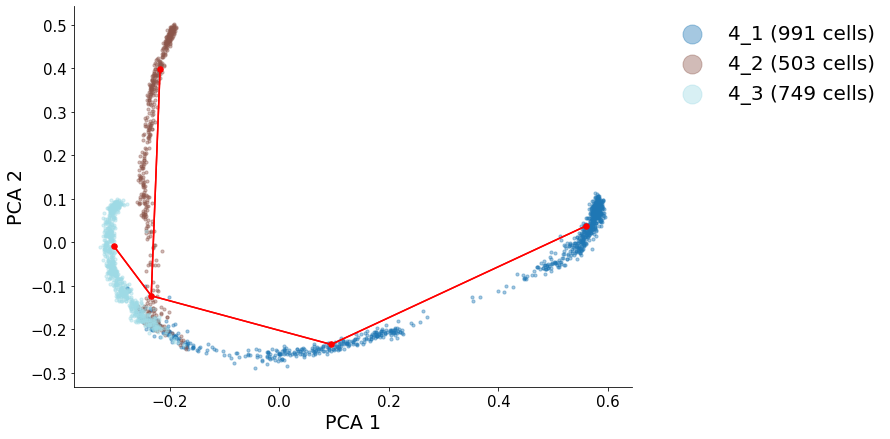

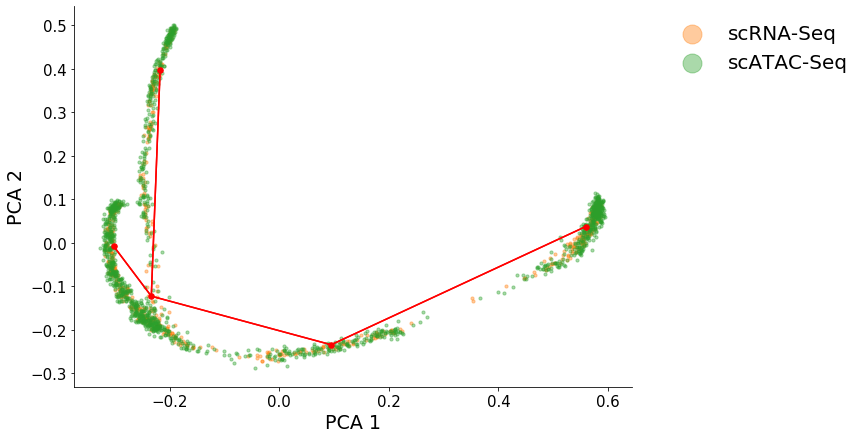

In [28]:
# The main difference this that there is only a small portion of the cells sampled from one batch
seeds = [0]
latent_dims = [4, 8, 32]
reg_ds = [1, 10]
reg_gs = [0.01, 1, 10]
reg_mmds = [1, 10, 20, 30]

latent_dim = latent_dims[1]
reg_d = reg_ds[0]
reg_g = reg_gs[1]
# harder to merge, need to make mmd loss larger
reg_mmd = reg_mmds[0]

learning_rate = 3e-4
n_epochs = 500
use_anchor = True
ts = [30, 50, 70]
use_potential = True
norm = "l1"

for seed in seeds:
    start_time = time.time()
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    data_name = "trifur2"
    counts_rna = pd.read_csv("../data/simulated/" + data_name + "/GxC1.txt", sep = "\t", header = None).values.T
    counts_atac = pd.read_csv("../data/simulated/" + data_name + "/RxC2.txt", sep = "\t", header = None).values.T
    label_rna = pd.read_csv("../data/simulated/" + data_name + "/cell_label1.txt", sep = "\t")["pop"].values.squeeze()
    label_atac = pd.read_csv("../data/simulated/" + data_name + "/cell_label2.txt", sep = "\t")["pop"].values.squeeze()
    # ground truth labels
    pt_rna = pd.read_csv("../data/simulated/" + data_name + "/pseudotime1.txt", header = None).values.squeeze()
    pt_atac = pd.read_csv("../data/simulated/" + data_name + "/pseudotime2.txt", header = None).values.squeeze()
    

    
    # preprocessing
    libsize = 100
    counts_rna = counts_rna/np.sum(counts_rna, axis = 1)[:, None] * libsize
    counts_rna = np.log1p(counts_rna)

    label_rna_new = np.where(label_rna == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0]) + " cells)", label_rna)
    label_rna_new = np.where(label_rna == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0]) + " cells)", label_rna_new)
    label_rna_new = np.where(label_rna == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0]) + " cells)", label_rna_new)
    label_atac_new = np.where(label_atac == "4_1", "4_1 (" + str(np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_atac)
    label_atac_new = np.where(label_atac == "4_2", "4_2 (" + str(np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_atac_new)
    label_atac_new = np.where(label_atac == "4_3", "4_3 (" + str(np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_atac_new)
    
    # calculate TI accuracy (pseudotime inferred separately)
    pca_op = PCA(n_components = 5)
    z_rna = pca_op.fit_transform(counts_rna)
    z_atac = pca_op.fit_transform(counts_atac)
    z_atac = diff.lsi_ATAC(X = counts_atac, k = 5)
    F1_rna, kt_rna = calc_score(z_rna, pt_rna, label_rna_new, plot = "ori_backbone_rna.png")
    F1_atac, kt_atac = calc_score(z_atac, pt_atac, label_atac_new, plot = "ori_backbone_atac.png")
    print("Accuracy (RNA), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_rna, kt_rna))
    print("Accuracy (ATAC), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_atac, kt_atac))    
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format((F1_rna + F1_atac)/2, (kt_rna + kt_atac)/2))

    
    # subsample, only sample on one batch
    # indices = np.array([True] * label_rna.shape[0])
    # remove_cells = np.random.choice(np.where(label_rna == "4_3")[0], 400, replace = False)
    # indices[remove_cells] = False
    # counts_rna = counts_rna[indices, :]
    # label_rna = label_rna[indices]
    # pt_rna = pt_rna[indices]

    # indices = np.array([True] * label_rna.shape[0])
    # remove_cells = np.random.choice(np.arange(indices.shape[0]), 700, replace = False)
    # indices[remove_cells] = False
    # counts_rna = counts_rna[indices, :]
    # label_rna = label_rna[indices]
    # pt_rna = pt_rna[indices]
    counts_rna = counts_rna[::2, :]
    label_rna = label_rna[::2]
    pt_rna = pt_rna[::2]
    
    # indices = np.array([True] * label_atac.shape[0])
    # remove_cells = np.random.choice(np.where(label_atac == "4_3")[0], 400, replace = False)
    # indices[remove_cells] = False
    # counts_atac = counts_atac[indices, :]
    # label_atac = label_atac[indices]
    # pt_atac = pt_atac[indices]

    print("remaining cells...")
    print("4_1, RNA", end = ", ")
    print(np.where(label_rna == "4_1")[0].shape[0])
    print("4_1, ATAC", end = ", ")
    print(np.where(label_atac == "4_1")[0].shape[0])
    print("4_2, RNA", end = ", ")
    print(np.where(label_rna == "4_2")[0].shape[0])
    print("4_2, ATAC", end = ", ")
    print(np.where(label_atac == "4_2")[0].shape[0])
    print("4_3, RNA", end = ", ")
    print(np.where(label_rna == "4_3")[0].shape[0])
    print("4_3, ATAC", end = ", ")
    print(np.where(label_atac == "4_3")[0].shape[0])

    label_rna_new = np.where(label_rna == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0] + np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_rna)
    label_rna_new = np.where(label_rna == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0] + np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_rna_new)
    label_rna_new = np.where(label_rna == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0] + np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_rna_new)
    label_atac_new = np.where(label_atac == "4_1", "4_1 (" + str(np.where(label_rna == "4_1")[0].shape[0] + np.where(label_atac == "4_1")[0].shape[0]) + " cells)", label_atac)
    label_atac_new = np.where(label_atac == "4_2", "4_2 (" + str(np.where(label_rna == "4_2")[0].shape[0] + np.where(label_atac == "4_2")[0].shape[0]) + " cells)", label_atac_new)
    label_atac_new = np.where(label_atac == "4_3", "4_3 (" + str(np.where(label_rna == "4_3")[0].shape[0] + np.where(label_atac == "4_3")[0].shape[0]) + " cells)", label_atac_new)
    
    
    pt = np.concatenate((pt_rna, pt_atac), axis = 0)
    label = np.concatenate((label_rna, label_atac), axis = 0)   
    
    # calculate TI accuracy (pseudotime inferred separately)
    pca_op = PCA(n_components = 5)
    z_rna = pca_op.fit_transform(counts_rna)
    z_atac = pca_op.fit_transform(counts_atac)
    z_atac = diff.lsi_ATAC(X = counts_atac, k = 6)
    F1_rna, kt_rna = calc_score(z_rna, pt_rna, label_rna_new, plot = "subsample2_backbone_rna.png")
    F1_atac, kt_atac = calc_score(z_atac, pt_atac, label_atac_new, plot = "subsample2_backbone_atac.png")
    print("Accuracy (RNA), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_rna, kt_rna))
    print("Accuracy (ATAC), F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1_atac, kt_atac))    
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format((F1_rna + F1_atac)/2, (kt_rna + kt_atac)/2))
#     # plot RNA
#     utils.plot_latent(z1 = z_rna, z2 = z_rna, anno1 = label_rna, 
#                   anno2 = label_rna, mode = "separate", save = None, 
#                   figsize = (30,10), axis_label = "PCA")
#     # plot ATAC
#     utils.plot_latent(z1 = z_atac, z2 = z_atac, anno1 = label_atac, 
#                   anno2 = label_atac, mode = "separate", save = None, 
#                   figsize = (30,10), axis_label = "PCA")
    # for un-equal cell type distribution, use anchor information
    rna_dataset = dataset.dataset(counts = counts_rna, anchor = np.argsort(pt_rna)[:10])
    atac_dataset = dataset.dataset(counts = counts_atac, anchor = np.argsort(pt_atac)[:10])
    
    # rna_dataset = dataset.dataset(counts = counts_rna, anchor = None)
    # atac_dataset = dataset.dataset(counts = counts_atac, anchor = None)
    coarse_reg = torch.FloatTensor(pd.read_csv("../data/simulated/" + data_name + "/region2gene.txt", sep = "\t", header = None).values).to(device)
    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        "gact_layers": [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        "proj_layers": [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        "learning_rate": learning_rate,
        "n_epochs": n_epochs + 1,
        "use_anchor": use_anchor,
        "reg_d": reg_d,
        "reg_g": reg_g,
        "reg_mmd": reg_mmd,
        "l_dist_type": "kl",
        "device": device
    }

    start_time = time.time()
    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                   use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    # quantile normalization
    # dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)
    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}
    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}
    # training models
    train_mmd.match_latent_batches(model = model_dict, opts = opt_dict, dist_atacs = [dist_atac], dist_rnas = [dist_rna], 
                    data_loaders_rna = [train_rna_loader], data_loaders_atac = [train_atac_loader], n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])
        
    # Plot results
    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]
#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
#                       anno2 = label_atac, mode = "separate", save = None, 
#                       figsize = (30,10), axis_label = "PCA")
    # post-maching
    z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)

    # calculate accuracy
    F1, kt = calc_score(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0), pt, label)
    print("Accuracy, F1 score: {:.2f}, Kendall-tau score: {:.2f}".format(F1, kt))
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]

#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
#                       anno2 = label_atac, mode = "separate", save = None, 
#                       figsize = (30,10), axis_label = "PCA")
    
    # calculate the diffusion distance
    root_cell = np.argmin(pt_rna)
    dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
    pt_infer = dpt_mtx[root_cell, :]
    pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
    pt_infer = pt_infer/np.max(pt_infer)

    pt_true = np.concatenate((pt_rna, pt_atac))
    pt_true[pt_true.argsort()] = np.arange(len(pt_true))
    pt_true = pt_true/np.max(pt_true)

    pt_rna = dpt_mtx[np.argmin(pt_rna), :z_rna.shape[0]]
    pt_atac = dpt_mtx[np.argmin(pt_rna), z_rna.shape[0]:]
    
    # backbone
    z = np.concatenate((z_rna, z_atac), axis = 0)
    cell_labels = np.concatenate((label_rna, label_atac), axis = 0).squeeze()
    
    # infer backbone with leiden clustering
    groups, mean_cluster, T = ti.backbone_inf(z, resolution = 0.05)
    groups_rna = groups[:counts_rna.shape[0]]
    groups_atac = groups[counts_rna.shape[0]:]
    root_clust = groups[root_cell]

    # infer all trajectories
    G = nx.from_numpy_matrix(T, create_using=nx.DiGraph)
    G = nx.dfs_tree(G, source = root_clust)
    paths = []
    for node in G:
        if G.out_degree(node)==0: #it's a leaf
            paths.append(nx.shortest_path(G, root_clust, node))

    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]    
    mean_cluster = pca_op.transform(np.array(mean_cluster))

    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = np.concatenate((label_rna_new, label_atac_new), axis = 0).squeeze(), 
                  T = T, mean_cluster = mean_cluster, mode = "joint", figsize=(10,7), 
                  save = "backbone2.png", axis_label = "PCA")
    
    plot_backbone(z_rna_pca, z_atac_pca, groups = groups, anno = np.array(["scRNA-Seq"] * z_rna_pca.shape[0] + ["scATAC-Seq"] * z_atac_pca.shape[0]), 
                  T = T, mean_cluster = mean_cluster, mode = "modality", figsize=(10,7), 
                  save = "backbone_mod2.png", axis_label = "PCA")
    

# Endo

In [ ]:
seeds = [0]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 1
reg_mmd = 1
ts = [30, 50, 70]
use_potential = True

seed = seeds[0]
print("Random seed: " + str(seed))
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

rna_dataset = dataset.endo_rna(counts_dir = "../data/Endo/counts_rna.csv", anno_dir = "../data/Endo/anno_rna.txt", anchor = "Endo (other)")
atac_dataset = dataset.endo_atac(counts_dir = "../data/Endo/counts_atac.csv", anno_dir = "../data/Endo/anno_atac.txt", anchor = "Endo (other)")
coarse_reg = torch.FloatTensor(pd.read_csv("../data/Endo/region2gene.csv", sep = ",", index_col = 0).values).to(device)

batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
libsize = rna_dataset.get_libsize()

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

EMBED_CONFIG = {
    'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
    'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
    'learning_rate': learning_rate,
    'n_epochs': n_epochs + 1,
    'use_anchor': use_anchor,
    'reg_d': reg_d,
    'reg_g': reg_g,
    'reg_mmd': reg_mmd,
    'l_dist_type': 'kl',
    'device': device
}


# calculate the diffusion distance
dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "pca", n_components = 30)

dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                use_potential = use_potential, dr = "lsi", n_components = 30)

# quantile normalization
# if EMBED_CONFIG["use_quantile"]:
#     dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

dist_rna = dist_rna/np.linalg.norm(dist_rna)
dist_atac = dist_atac/np.linalg.norm(dist_atac)
dist_rna = torch.FloatTensor(dist_rna).to(device)
dist_atac = torch.FloatTensor(dist_atac).to(device)

# initialize the model
gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
model_dict = {"gene_act": gene_act, "encoder": encoder}

opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

# training models
train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = "l1", 
                mode = EMBED_CONFIG["l_dist_type"])

with torch.no_grad():
    z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
    z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

np.save(file = "../test/results_endo/z_rna2.npy", arr = z_rna.numpy())
np.save(file = "../test/results_endo/z_atac2.npy", arr = z_atac.numpy())

# Hema

In [ ]:
# seeds = [0, 1, 2, 3, 4]
seeds = [2]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 1
reg_mmd = 1
ts = [30, 50, 70]
use_potential = True
norm = "l1"

for seed in seeds:
    print("Random seed: " + str(seed))
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    rna_dataset = dataset.hema_rna(counts_dir = "../data/hema/counts_rna.csv", anno_dir = "../data/hema/anno_rna.txt", anchor = "MEP")
    atac_dataset = dataset.hema_atac(counts_dir = "../data/hema/counts_atac.csv", anno_dir = "../data/hema/anno_atac.txt", anchor = "MEP")
    coarse_reg = torch.FloatTensor(pd.read_csv("../data/hema/region2gene.csv", sep = ",", index_col = 0).values).to(device)

    batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
    libsize = rna_dataset.get_libsize()

    train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
    train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)

    EMBED_CONFIG = {
        'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
        'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
        'learning_rate': learning_rate,
        'n_epochs': n_epochs + 1,
        'use_anchor': use_anchor,
        'reg_d': reg_d,
        'reg_g': reg_g,
        'reg_mmd': reg_mmd,
        'l_dist_type': 'kl',
        'device': device
    }


    # calculate the diffusion distance
    dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "pca", n_components = 30)

    dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
                                    use_potential = use_potential, dr = "lsi", n_components = 30)

    # quantile normalization
    # if EMBED_CONFIG["use_quantile"]:
    #     dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)

    dist_rna = dist_rna/np.linalg.norm(dist_rna)
    dist_atac = dist_atac/np.linalg.norm(dist_atac)
    dist_rna = torch.FloatTensor(dist_rna).to(device)
    dist_atac = torch.FloatTensor(dist_atac).to(device)

    # initialize the model
    gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
    model_dict = {"gene_act": gene_act, "encoder": encoder}

    opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
    opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
    opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

    # training models
    train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                    data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
                    reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = norm, 
                    mode = EMBED_CONFIG["l_dist_type"])

    with torch.no_grad():
        z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
        z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()

#     np.save(file = "../test/results_hema/z_rna.npy", arr = z_rna.numpy())
#     np.save(file = "../test/results_hema/z_atac.npy", arr = z_atac.numpy())

    # post-maching
    z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
    z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)
    
    pca_op = PCA(n_components = 2)
    z = pca_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_pca = z[:z_rna.shape[0],:]
    z_atac_pca = z[z_rna.shape[0]:,:]

    utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, 
                      anno2 = atac_dataset.cell_labels, mode = "separate", save = None, 
                      figsize = (30,10), axis_label = "PCA")

    umap_op = UMAP(n_components = 2, min_dist = 0.8, random_state = 0)
    z = umap_op.fit_transform(np.concatenate((z_rna.numpy(), z_atac.numpy()), axis = 0))
    z_rna_umap = z[:z_rna.shape[0],:]
    z_atac_umap = z[z_rna.shape[0]:,:]
    utils.plot_latent(z1 = z_rna_umap, z2 = z_atac_umap, anno1 = rna_dataset.cell_labels, 
                      anno2 = atac_dataset.cell_labels, mode = "separate", save = None, 
                      figsize = (30,10), axis_label = "UMAP")


#     # post-maching
#     pca_op = PCA(n_components = 2)
#     z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
#     z_rna_pca = z[:z_rna.shape[0],:]
#     z_atac_pca = z[z_rna.shape[0]:,:]
#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, 
#                         anno2 = atac_dataset.cell_labels, mode = "joint", save = "../test/results_hema/z_joint_post.png", 
#                         figsize = (10,7), axis_label = "PCA")
#     utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = rna_dataset.cell_labels, 
#                         anno2 = atac_dataset.cell_labels, mode = "modality", save = "../test/results_hema/z_mod_post.png", 
#                         figsize = (10,7), axis_label = "PCA")

#     umap_op = UMAP(n_components = 2, min_dist = 0.8, random_state = 0)
#     z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
#     z_rna_umap = z[:z_rna.shape[0],:]
#     z_atac_umap = z[z_rna.shape[0]:,:]
#     utils.plot_latent(z1 = z_rna_umap, z2 = z_atac_umap, anno1 = rna_dataset.cell_labels, 
#                         anno2 = atac_dataset.cell_labels, mode = "joint", save = "../test/results_hema/z_joint_post_umap.png", 
#                         figsize = (10,7), axis_label = "UMAP")
#     utils.plot_latent(z1 = z_rna_umap, z2 = z_atac_umap, anno1 = rna_dataset.cell_labels, 
#                         anno2 = atac_dataset.cell_labels, mode = "modality", save = "../test/results_hema/z_mod_post_umap.png", 
#                         figsize = (10,7), axis_label = "UMAP")

# hema full

In [ ]:
rna_dataset = dataset.hema_full_rna(counts_dir = "../data/hema_full/compress/counts_rna.npz", anno_dir = "../data/hema_full/anno_rna.csv", anchor = "11_CD14.Mono.1")
atac_dataset = dataset.hema_full_atac(counts_dir = "../data/hema_full/compress/counts_atac.npz", anno_dir = "../data/hema_full/anno_atac.csv", anchor = "11_CD14.Mono.1")
coarse_reg = torch.FloatTensor(load_npz("../data/hema_full/compress/gact.npz").todense()).to(device)

batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)
libsize = rna_dataset.get_libsize()

train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)


In [ ]:
EMBED_CONFIG = { 
    'layers': [rna_dataset.counts.shape[1], 512, 128, 32], # number of nodes in each 
    'use_quantile': True
}

In [ ]:
for data in test_rna_loader:
#     dist_rna = diff.phate_similarity(data["count"].numpy(), 
#                                   n_neigh = 5, 
#                                   t = 20, 
#                                   use_potential = True,
#                                   method = "exact",
#                                   decay = 40,
#                                   thresh = 0)
    
    dist_rna = diff.diffu_distance(data["count"].numpy(), ts = [50, 100], use_potential = False, 
                                   dr = "pca", n_components = 30, method = "fast", n_anchor = 2000)



for data in test_atac_loader:
    # note, do lsi before calculating the distance
#     data_reduced = diff.lsi_ATAC(data["count"].numpy(), k = 100, use_first = False)
#     dist_atac = diff.phate_similarity(data_reduced, 
#                                   n_neigh = 5, 
#                                   t = 20,
#                                   use_potential = True,
#                                   method = "exact",
#                                   decay = 40,
#                                   thresh = 0)
    
    dist_atac = diff.diffu_distance(data["count"].numpy(), ts = [50, 100], use_potential = False, 
                                    dr = "lsi", n_components = 30, method = "fast", n_anchor = 2000)
# quantile normalization
dist_rna = dist_rna/np.linalg.norm(dist_rna)
dist_atac = dist_atac/np.linalg.norm(dist_atac)

if EMBED_CONFIG["use_quantile"]:
    if dist_rna.shape[0] >= dist_atac.shape[0]:
        reference = dist_rna.reshape(-1)
    else:
        reference = dist_atac.reshape(-1)

#     dist_atac = diff.quantile_norm(dist_atac, reference = dist_rna.reshape(-1), replace = True)



dist_rna = torch.FloatTensor(dist_rna).to(device)
dist_atac = torch.FloatTensor(dist_atac).to(device)




In [ ]:
gene_act = model.gene_act(features = [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], dropout_rate = 0.0, negative_slope = 0.2).to(device)

encoder = model.Encoder(features = EMBED_CONFIG["layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
decoder = model.Decoder(features = EMBED_CONFIG["layers"][::-1], dropout_rate = 0.0, negative_slope = 0.2).to(device)


model_dict = {"gene_act": gene_act, "encoder": encoder, "decoder": decoder}

In [ ]:
learning_rate = 3e-4
opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
opt_decoder = torch.optim.Adam(decoder.parameters(), lr = learning_rate)

opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder, "decoder": opt_decoder}

In [ ]:
# model_dict = torch.load("model_hema_full_mmd_latent32.pt", map_location = torch.device("cuda"))

In [ ]:
train_mmd.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
                   data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = 201, 
                   reg_mtx = coarse_reg, reg_d = 1, reg_g = 0.001, reg_mmd = 1, use_anchor = False, norm = "l1", 
                   mode = "kl")

In [ ]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = model_dict["encoder"](data['count'].to(device)).cpu().detach()

    for data in test_atac_loader:
        ae_coordinates2 = model_dict["encoder"](model_dict["gene_act"](data['count'].to(device))).cpu().detach()

pca_op = PCA(n_components = 2)
ae_coord = pca_op.fit_transform(np.concatenate((ae_coordinates1, ae_coordinates2), axis = 0))
ae_coordinates1 = ae_coord[:ae_coordinates1.shape[0],:]
ae_coordinates2 = ae_coord[ae_coordinates1.shape[0]:,:]

utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, 
                  anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, 
                  mode = "joint",save = None, figsize = (20,10), axis_label = "PCA")



In [ ]:
utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, 
                  anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, 
                  mode = "modality",save = None, figsize = (10,7), axis_label = "PCA")

In [ ]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = model_dict["encoder"](data['count'].to(device)).cpu().detach()

    for data in test_atac_loader:
        ae_coordinates2 = model_dict["encoder"](model_dict["gene_act"](data['count'].to(device))).cpu().detach()
        
ae_coordinates2, ae_coordinates1 = palign.match_alignment(z_rna = ae_coordinates2, z_atac = ae_coordinates1, k = 5)        
ae_coordinates1, ae_coordinates2 = palign.match_alignment(z_rna = ae_coordinates1, z_atac = ae_coordinates2, k = 5)

pca_op = PCA(n_components = 2)
ae_coord = pca_op.fit_transform(np.concatenate((ae_coordinates1, ae_coordinates2), axis = 0))
ae_coordinates1 = ae_coord[:ae_coordinates1.shape[0],:]
ae_coordinates2 = ae_coord[ae_coordinates1.shape[0]:,:]

utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, 
                  anno2 = atac_dataset.cell_labels, mode = "joint",save = None, figsize = (10,7), 
                  axis_label = "PCA")

In [ ]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = model_dict["encoder"](data['count'].to(device)).cpu().detach()

    for data in test_atac_loader:
        ae_coordinates2 = model_dict["encoder"](model_dict["gene_act"](data['count'].to(device))).cpu().detach()

ae_coordinates2, ae_coordinates1 = palign.match_alignment(z_rna = ae_coordinates2, z_atac = ae_coordinates1, k = 5)        
ae_coordinates1, ae_coordinates2 = palign.match_alignment(z_rna = ae_coordinates1, z_atac = ae_coordinates2, k = 5)


umap_op = UMAP(n_components = 2, n_neighbors = 1000, min_dist = 1.0)
ae_coord = umap_op.fit_transform(np.concatenate((ae_coordinates1, ae_coordinates2), axis = 0))
ae_coordinates1 = ae_coord[:ae_coordinates1.shape[0],:]
ae_coordinates2 = ae_coord[ae_coordinates1.shape[0]:,:]

In [ ]:
utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, 
                  anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, 
                  mode = "joint",save = None, figsize = (20,10), axis_label = "UMAP")

In [ ]:
utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, 
                  anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, 
                  mode = "modality",save = "hema_full_modality.png", figsize = (10,7), axis_label = "UMAP")

In [ ]:
utils.plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, 
                  anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, 
                  mode = "separate",save = None, figsize = (20,7), axis_label = "UMAP")

In [ ]:
# torch.save(model_dict, "model_hema_full_mmd_latent32.pt")